In [313]:
# data manipulation modules
import pandas as pd
import numpy as np
from numpy import linalg as LA1
from scipy import misc
import seaborn as sns

from scipy.spatial import distance

import scipy.special

from skimage import color
from skimage import io

# plot modules
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from itertools import cycle


# csv modules
import csv

# image manipulation modules
from PIL import Image

# path modules
from pathlib import Path

# system modules
import os

# misc modules
import random
import time


""" GLOBALS """
image_dir_path = 'Desktop/images/'
centroids = []



In [314]:

class PCA():
    
    def __init__(self, n_components):
        self.n_components = n_components
        self.principal_components = np.empty([n_components])
        self.m = 0

    
    def fit(self, X):
        
    
        # Fit the model with X.
        
        self.m = np.mean(X, axis=0)
        
        #lst = np.array([(X[i]- self.m) * np.vstack((X[i] - self.m)) for i in range(len(X))])
        #cov_matrix = np.sum(np.stack(lst, axis=0), axis=0) / len(X)
 
        cov_matrix = np.cov(X.T)  # 0.35 secs
       
    
        cov_matrix_eig = LA1.eig(cov_matrix)    
      

        
   
        self.principal_components = np.array([cov_matrix_eig[1][:, i] for i in (cov_matrix_eig[0].argsort()[-self.n_components:][::-1])])
        
        
    
    def transform(self, X):
        # Apply dimensionality reduction to X.
        transformed_dataset = [np.dot(self.principal_components, X[i]) for i in range(len(X))]
       
        
        return transformed_dataset
def keywithmaxval(d):
    v = list(d.values())
    k = list(d.keys())
    return k[v.index(max(v))]


class kmeans():
    
    def __init__(self, k, init):
        self.k = k
        self.init = init
        self.centroids = []
        
    
    def kmeans_pp_init(self, X):
        start = time.time()
        cluster_indices = []
        
        first_cluster_idx = random.randrange(0, len(X))
        
        self.centroids.append(X[first_cluster_idx])
        cluster_indices.append(first_cluster_idx)
        
        for i in range(self.k - 1):
            distances = {}
            
            for xi_idx, xi in enumerate(X):
                # for each element of X
                for j in cluster_indices:
                    #np.linalg.norm(xi - X[j])
                    #distance.cosine(xi, X[j])
                    aux_distances = [np.linalg.norm(xi - X[j]) for j in cluster_indices]
                # find the distance to nearest centroid to xi
                distances[xi_idx] = min(aux_distances)
            
            # the new centroid is the one with the greatest distance to its nearest centroid.
            new_centroid = keywithmaxval(distances)
            self.centroids.append(X[new_centroid])
            cluster_indices.append(new_centroid)  
    
    def vanilla_init(self, X):
        self.centroids = [X[random.randrange(0, len(X))] for i in range(self.k)]
    
    def fit_predict(self, X):
        global centroids
        
        if self.init == "kmeans++":
            self.kmeans_pp_init(X)
        else:
            self.vanilla_init(X)
        
        
        
        E_old = 0
        flag = 0
        
        while True:
            clusters = [[] for i in range(self.k)]
            distances = []
            labels = []
            
            for xi in X:
                # distance.cosine(xi, j)
                # np.linalg.norm(xi - j)
                distances_centroids = [np.linalg.norm(xi - j) for j in self.centroids]
                distances.append(min(distances_centroids))
                clusters[np.argmin(distances_centroids)].append(xi)
                labels.append(np.argmin(distances_centroids))
            
        
            E_new = sum(distances)
            if flag == 1:
                if E_old - E_new <= 0:
                    centroids = self.centroids
                    break
            else:
                flag = 1
            
            E_old = E_new
        
            
            for i in range(len(self.centroids)):
                self.centroids[i] =  np.mean(np.array(clusters[i]), axis=0)
                            
        return labels        



        
        
        
        
            
        
    

    
    

In [315]:
def grayscale_and_convert_to_nparray(img_path: str):
    
    img = Image.open(img_path)
    imgGray = img.convert('L')

    gray_img = np.asarray(imgGray) / 255
    return gray_img.flatten()


def load_data(image_dir_path):
    
    dataset_img_names = np.zeros(shape=(0, 4096))
   

    for dirpath, dirnames, filenames in os.walk(image_dir_path):
        for directory in dirnames:
            for img_name in list(os.listdir(image_dir_path + directory))[:50]:
                img_path = "".join([image_dir_path, directory, "/", img_name])
               
                vec = grayscale_and_convert_to_nparray(img_path)
                dataset_img_names = np.vstack([dataset_img_names, vec])
    return dataset_img_names


In [316]:
def most_common(lst):
    return max(set(lst), key=lst.count)

def purity(labels):
    summ = 0
    for i in range(0, 500, 50):
        most_freq = most_common(labels[i:i+50])
        print(most_freq)
        summ += labels[i:i+50].count(most_freq)
    return summ / len(labels)

def calculate_tp(lst):
    lst2 = [i for i in set(lst) if lst.count(i) > 1]

    lst3 = [scipy.special.binom(i, 2) for i in set([lst.count(i) for i in lst if i in lst2])]
    
    return sum(lst3)

def segment_lst(lst):
    new_lst = []
    for i in range(0, 500, 50):
        new_lst.append(lst[i:i+50])
    return new_lst

def calculate_fn(lst):
    most_apprncs = [[0] * 10 for i in range(10)]
    lst = segment_lst(lst)

    final = []
    for i in lst:
        aux_lst = []
        for k in range(len(lst)):
            aux_lst.append(i.count(k + 1))
        final.append(aux_lst)

    final2 = [[] for i in range(len(final))]
    for i in range(len(final2)):
        for j in final:
            final2[i].append(j[i])

    summ = 0
    for i in final2:    
        summ += max(i) * (sum(i)-max(i))
        aux_final2 = i
        aux_final2.remove(max(aux_final2))
    
        for j in range(len(aux_final2)):
            for k in range(j + 1, len(aux_final2)):
                summ += aux_final2[j] * aux_final2[k]
            
    return summ
    

def f1_score(labels):
    tp_fp = 0
    tp = 0
    fn = calculate_fn(labels)
    
    for i in range(0, 500, 50): 
        n = len(set(labels[i:i+50]))
        tp_fp += scipy.special.binom(n, 2)
        tp += calculate_tp(labels[i:i+50])
        
    precision = tp / tp_fp 
    recall = tp / tp + fn
    
    return (2 * (precision * recall)) / (precision + recall)



X = load_data(image_dir_path)


pca = PCA(n_components=100)
pca.fit(X)
trans_dataset = pca.transform(X)

kmeans = kmeans(k=3, init="kmeans++")
labels = kmeans.fit_predict(trans_dataset)

#print(labels)
print("Purity = " + str(purity(labels) * 100) + "%")
f1 = f1_score(labels)
if f1 >= 100:
    print("F1_score = 100%")
else:
    print("F1_score = " + str(round(f1, 2) + "%"))



0
0
0
0
0
0
2
0
0
0
Purity = 59.4%
F1_score = 100%


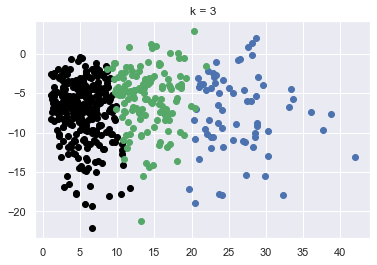

In [317]:
def plot_clusters(labels):
    clusters = [[] for i in range(3)]
    for idx, el in enumerate(labels):
        clusters[el].append(trans_dataset[idx])


    
    color_lst = ['black', 'b', 'g', 'r', 'y', 'pink', 'orange', 'purple', 'c', 'olive']

    for idx, el in enumerate(clusters):
        xpoints = np.vstack(el)[:,0]
        ypoints = np.vstack(el)[:,1]
            
        plt.scatter(xpoints, ypoints, c=color_lst[idx])
    
    plt.title("k = 3")
    plt.show()

    
plot_clusters(labels)